In [1]:
# 数据路径
DATA_PATH = './cifar/'
# 如果数据集不存在是否下载数据集
DOWNLOAD_DATASET = True
# 批量大小
BATCH_SIZE = 50
# 设置是否使用GPU
USEGPU = True

In [2]:
# 用于读取表格数据
import pandas as pd
# 用于构建神经网络和相应数据处理
import torch
import torch.utils.data
import torch.nn as nn
import torchvision
# 用于图像的读取和基本处理
import cv2 as cv
# 用于支持其他模块以及非torch的矩阵操作
import numpy as np
# 用于显示图像
import matplotlib.pyplot as plt
# 用于计算训练用时
import datetime
# 用于XML文件读写
import xml.etree.ElementTree as ElementTree

In [3]:
# 确定正在使用的运算设备
if USEGPU:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = 'cpu'

print('using',device)

using cuda:0


In [4]:
# 这一部分把三个通道合到一起计算了。
# 应该分开算

# 如果没有记录的平均值和标准差
# 就计算训练集的平均值和标准差并保存
# 如果已经存在
# 则读取均值和方差
# 初始化平均值和标准差的存储变量
datasetMean = 0
datasetStd = 0
# 初始化文件路径
xmlFilePath = DATA_PATH+'TrainsetMeanAndStd.xml'
# 尝试读取数据
try:
    tree = ElementTree.parse(xmlFilePath)
    rootNode = tree.getroot()
    for node in rootNode:
        if node.tag == 'mean':
            datasetMean = float(node.attrib['value'])
        elif node.tag =='std':
            datasetStd = float(node.attrib['value'])
except:
    # 如果读取失败则重新计算均值和方差
    # 计算均值和方差之前先要保证训练集存在
    train_data = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True,download=DOWNLOAD_DATASET, 
                                        transform=torchvision.transforms.ToTensor())
    print('计算训练集数据均值和方差中')
    # 计算平均值
    tempSum = 0
    for i, data in enumerate(train_data):
        img, label = data
        tempSum = tempSum + float(img.mean())
    datasetMean = tempSum/len(train_data)
    # 计算标准差
    tempSum = 0
    for i, data in enumerate(train_data):
        img, label = data
        tempSum = tempSum + float(((img-datasetMean)**2).mean())
    datasetStd = (tempSum/len(train_data))**0.5
    print('计算完毕')
    # 生成XML并保存
    rootNode = ElementTree.Element('root')
    meanNode = ElementTree.SubElement(rootNode,'mean')
    meanNode.attrib = {'value':str(datasetMean)}
    stdNode = ElementTree.SubElement(rootNode,'std')
    stdNode.attrib = {'value':str(datasetStd)}
    tree = ElementTree.ElementTree(rootNode)
    # 生成的XML保存于DATA_PATH路径之下
    tree.write(xmlFilePath)
print('mean',datasetMean)
print('std',datasetStd)

mean 0.4733630244453624
std 0.2515689271173141


In [5]:
# 如果上边改成三通道这里也要修改
datasetMean = (datasetMean,datasetMean,datasetMean)
datasetStd = (datasetStd,datasetStd,datasetStd)
# CIFAR数据集载入
# 图像数据的归一化和正则化
# 需要注意的是ToTensor转化器在加载数据的时候已经把图像像素值从[0,255]变成了[0.0,1.0]
# 载入MNIST数据集
# ToTensor可以把像素数据整理到[0.0,1.0]区间。

# 构造转换器
TF = torchvision.transforms
transformFunction = TF.Compose([TF.ToTensor(),
                                TF.Normalize(mean=datasetMean,std=datasetStd)
                               ])
#transformFunction = TF.Compose([TF.ToTensor(),])
# 载入训练集和测试集
train_data = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True,download=DOWNLOAD_DATASET, 
                                        transform=transformFunction)
test_data = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False,download=DOWNLOAD_DATASET, 
                                        transform=transformFunction)
# 用DataLoader把数据集打包起来
Data = torch.utils.data
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
# 定义网络
import torch.nn as nn
import torch.nn.functional as F
class ClassificationCIFAR10(nn.Module):
    def __init__(self):
        super(ClassificationCIFAR10,self).__init__()
        self.n1=nn.Sequential(nn.Conv2d(3, 4, 3, 1),nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.n2=nn.Sequential(nn.Conv2d(4, 8, 3, 1),nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        #self.n3=nn.Sequential(nn.Conv2d(8, 16, 3, 1),nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.fc1 = nn.Linear(8*6*6,10)
        #self.fc2 = nn.Linear(33,15)
        
    def forward(self, x):
        x = self.n1(x)
        x = self.n2(x)
        #x = self.n3(x)
        x = x.view(-1,8*6*6)
        x = self.fc1(x)
       #x = self.fc2(x)
        #output = (torch.sigmoid(x)).round()
        output = torch.sigmoid(x)
        return output

In [34]:
# 初始化网络，及相关函数
cnn=ClassificationCIFAR10().to(device)
EPOCH = 20
#LR = 0.001
#LR = 0.0001
# 学习率是个超参数，这东西是实验出来的
#LR = 0.001
LR = 0.0001

# 定义损失函数和优化器
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = torch.nn.CrossEntropyLoss(size_average=False)

In [35]:
# 进行训练
torch.cuda.synchronize()
starttime=datetime.datetime.now()
# 训练
for epoch in range(EPOCH):
    for i,data in enumerate(train_loader):
        # 获取数据并把训练用数据转移到GPU上
        b_x,b_y = data
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        # 前馈和计算损失
        output = cnn(b_x)
        loss = loss_func(output, b_y)
        # 反馈
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i% 500 == 0:
            for j,testdata in enumerate(test_loader):
                tx,ty =testdata
                tx = tx.to(device)
                ty = ty.to(device)
                test_output = cnn(tx)
                # !!!!!!!! Change in here !!!!!!!!! #
                pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU
                accuracy = torch.sum(pred_y == ty).type(torch.FloatTensor) / ty.size(0)
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.2f' % accuracy)
                break
 

torch.cuda.synchronize()
endtime=datetime.datetime.now()
print('Train time:',(endtime-starttime).seconds,'seconds')

Epoch:  0 | train loss: 114.8623 | test accuracy: 0.06
Epoch:  0 | train loss: 108.0949 | test accuracy: 0.30
Epoch:  1 | train loss: 106.2955 | test accuracy: 0.32
Epoch:  1 | train loss: 97.9107 | test accuracy: 0.34
Epoch:  2 | train loss: 102.7084 | test accuracy: 0.34
Epoch:  2 | train loss: 102.7250 | test accuracy: 0.36
Epoch:  3 | train loss: 99.1931 | test accuracy: 0.40
Epoch:  3 | train loss: 100.7133 | test accuracy: 0.48
Epoch:  4 | train loss: 99.9203 | test accuracy: 0.32
Epoch:  4 | train loss: 97.9620 | test accuracy: 0.34
Epoch:  5 | train loss: 99.8813 | test accuracy: 0.38
Epoch:  5 | train loss: 103.1572 | test accuracy: 0.26
Epoch:  6 | train loss: 97.0090 | test accuracy: 0.48
Epoch:  6 | train loss: 97.5128 | test accuracy: 0.38
Epoch:  7 | train loss: 98.4744 | test accuracy: 0.50
Epoch:  7 | train loss: 96.1019 | test accuracy: 0.42
Epoch:  8 | train loss: 97.1707 | test accuracy: 0.32
Epoch:  8 | train loss: 101.0184 | test accuracy: 0.46
Epoch:  9 | train lo

In [11]:
# MNIST数据集载入
# 图像数据的归一化和正则化
# 需要注意的是ToTensor转化器在加载数据的时候已经把图像像素值从[0,255]变成了[0.0,1.0]
# 载入MNIST数据集
# ToTensor可以把像素数据整理到[0.0,1.0]区间。

# 构造转换器
TF = torchvision.transforms

#transformFunction = TF.Compose([TF.ToTensor(),])
# 载入训练集和测试集
test_data = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False,download=DOWNLOAD_DATASET, 
                                        transform=TF.ToTensor())


Files already downloaded and verified


(tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
         [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
         [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
         ...,
         [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
         [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
         [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

        [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
         [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
         [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
         ...,
         [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
         [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
         [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

        [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
         [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
         [0.1843, 0.1294, 0.1412,  ..., 0.1333, 0.1333, 0

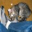

In [12]:
#展示图像
import PIL
ToPIL = torchvision.transforms.ToPILImage()
#ToPIL(torchvision.utils.make_grid(L[0])).show()
x=0
for i,data in enumerate(test_data):
    print(data)
    x= ToPIL(data[0])
    break
x

In [29]:
cnn = ClassificationCIFAR10()
n1=nn.Sequential(nn.Conv2d(3, 4, 3, 1),nn.ReLU(), nn.MaxPool2d(kernel_size=2))
n2=nn.Sequential(nn.Conv2d(4, 8, 3, 1),nn.ReLU(), nn.MaxPool2d(kernel_size=2))
for i,data in enumerate(test_loader):
    print(data[0].size())
    print(n2(n1(data[0])).size())
    print(cnn(data[0]).size())
    break
    #print(cnn(data[0]))
    pass

torch.Size([50, 3, 32, 32])
torch.Size([50, 8, 6, 6])
torch.Size([50, 10])


In [ ]:
# CIFAR10的最高正确率高于80的有很多。但是Pytorch官方教程和这个网络的正确率都在50左右。
# 分析一下可能因为CIFAR10的图片不统一。例如同样是狗，有的给的狗头，有的给的狗身子。虽然图片小，但是问题是比较复杂的。
# 因此目前不太纠结这个